# Covertype

In [1]:
%load_ext autoreload
import sys
import os
sys.path.append("/home/lauro/code/msc-thesis/svgd/kernel_learning/")
from jax import config
config.update("jax_debug_nans", False)
from tqdm import tqdm
from jax import config


import jax.numpy as jnp
import jax.numpy as np
from jax import grad, jit, vmap, random, lax, jacfwd, value_and_grad
from jax.ops import index_update, index
import matplotlib.pyplot as plt
import matplotlib
import numpy as onp
import jax
import pandas as pd
import scipy
import haiku as hk
    
import utils
import plot
import distributions
import stein
import models
import flows
from itertools import cycle, islice
    
key = random.PRNGKey(0)

from sklearn.model_selection import train_test_split

from functools import partial
import kernels

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
sns.set(style='white')

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
tfpk = tfp.math.psd_kernels

/home/lauro/.virtualenvs/msc-thesis/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


# Data

In [2]:
data = scipy.io.loadmat('/home/lauro/code/msc-thesis/wang_svgd/data/covertype.mat')
features = data['covtype'][:, 1:]
features = onp.hstack([features, onp.ones([features.shape[0], 1])]) # add intercept term

labels = data['covtype'][:, 0]
labels[labels == 2] = 0

x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

num_features = features.shape[-1]
num_classes = len(onp.unique(labels))

In [3]:
default_batch_size = 300
def get_batches(x, y, n_steps=500, batch_size=default_batch_size):
    """Split x and y into batches"""
    assert len(x) == len(y)
    n = len(x)
    idxs = onp.random.choice(n, size=(n_steps, batch_size))
    for idx in idxs:
        yield x[idx], y[idx]
#     batch_cycle = cycle(zip(*[onp.array_split(data, len(data)//batch_size) for data in (x, y)]))
#     return islice(batch_cycle, n_steps)

num_batches = len(x_train) // default_batch_size

In [4]:
# def get_batches(x, y, n_steps=500, batch_size=100):
#     """Split x and y into batches"""
#     assert len(x) == len(y)
#     batch_cycle = cycle(zip(*[onp.array_split(data, len(data)//batch_size) for data in (x, y)]))
#     return islice(batch_cycle, n_steps)

# num_batches = len(x_train) // 100

In [5]:
# batches = get_batches(x_train, y_train, batch_size=5)

# Model

We can define the model using `tfd.JointDistributionCoroutine`.

### TODO: try adagrad / adadelta / adam???

### TODO file bug: gamma pdf wrong in tfd

skip assert _assert_compare_to_zero


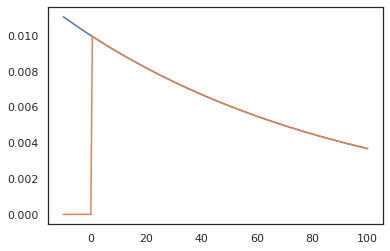

In [6]:
a0, b0 = 1, 0.01 # hyper-parameters
t = tfd.Gamma(a0, b0, validate_args=True)
gamma_pdf = lambda x: jax.scipy.stats.gamma.pdf(x, a0, 0, 1/b0)
plot.plot_fun(t.prob, lims=(-10,100))
plot.plot_fun(gamma_pdf, lims=(-10, 100))

In [7]:
a0, b0 = 1, 0.01 # hyper-parameters
# note that b0 is inverse scale, so this means alpha big, 1/alpha small! gaussian narrow! dunno why, check paper

a0, b0 = 1, 10 # b approx equals variance

Root = tfd.JointDistributionCoroutine.Root

def get_model(features_batch):
    def model():
        """generator"""
        log_alpha = yield Root(tfd.ExpGamma(a0, b0, name="log_alpha"))                                      # scalar
        w = yield tfd.Sample(tfd.Normal(0., 1/np.exp(log_alpha/2)), sample_shape=(num_features,), name="w") # shape (num_features,)
        log_odds = jnp.dot(features_batch, w)                                                               # shape (len(features_batch),)
        _ = yield tfd.Independent(tfd.Bernoulli(logits=log_odds), name="labels")                            # shape (len(features_batch),) in {0, 1}
    return model


def get_logp(x_batch, y_batch):
    """Stochastic estimate of the log-density (up to additive constant)
    based on batch"""
    def logp(params):
        dist = tfd.JointDistributionCoroutineAutoBatched(get_model(x_batch), validate_args=True)
        return dist.log_prob(tuple(params) + (y_batch,))
    return logp


dist = tfd.JointDistributionCoroutineAutoBatched(get_model(x_train[:7]))
key, subkey = random.split(key)
dist.sample(seed=subkey)

StructTuple(
  log_alpha=DeviceArray(-3.8738952, dtype=float32),
  w=DeviceArray([  2.99173   ,  13.088244  ,  -8.02397   ,   2.6047595 ,
                  -5.8925276 ,   4.2483954 ,   5.612577  , -10.234691  ,
                   0.4712759 ,   9.1408825 ,  -3.0934024 ,  13.507301  ,
                  -4.0262074 ,   5.252132  ,   6.978037  ,   5.6979246 ,
                  -1.6318034 , -16.315622  ,   5.932049  ,  -7.1938972 ,
                  -5.4601707 ,  -5.2462344 ,  12.777466  ,  -5.5773425 ,
                   9.6707735 ,   2.8172088 ,  12.814096  ,  -0.9641641 ,
                  -8.550417  ,   7.1835504 ,  11.952571  ,   0.6710275 ,
                 -11.926304  ,  -1.9040103 ,   4.494909  ,  -0.51020527,
                 -10.909989  ,   4.9146194 ,   6.0395107 ,   2.2693117 ,
                  -0.14474118,   2.8920102 , -19.107708  ,   1.4781501 ,
                   2.9134803 ,   4.0553265 ,   4.913479  ,  -3.6105433 ,
                   1.2517713 ,  -3.6519215 ,  -6.0565505 , 

In [8]:
key, subkey = random.split(key)
_, w, labels = dist.sample(seed=subkey)
def pdf(log_alpha):
    return dist.prob((log_alpha, w, labels))

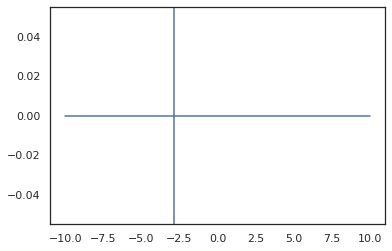

In [9]:
# plot.plot_fun(tfd.ExpGamma(a0, b0).prob, lims=(-10, 10))

plot.plot_fun(pdf, lims=(-10, 10))
log_alpha = np.log(np.var(w))
plt.axvline(x=-log_alpha) # makes sense, since 1/alpha \approx Var(w)

Note that we have two distinct types of batching going on: we're using batches of data to estimate the gradient $\nabla \log p$, and then we're mapping that gradient over a set of particles.

In [10]:
batches = get_batches(x_train, y_train, batch_size=5)
x, y = next(batches)
del batches
logp = get_logp(x, y)

dist = tfd.JointDistributionCoroutineAutoBatched(get_model(x), validate_args=True)
*params, labels = dist.sample(seed=key)
print(dist.log_prob(params + [y]))
print(logp(params))

# now batched!
key, subkey = random.split(key)
*params, labels = dist.sample(7, seed=subkey)
print(vmap(logp)(params))
print(logp(params))

-174.49713
-174.49713
[-157.49666 -161.99422 -193.6632  -129.59654 -170.48044 -157.1572
 -142.52945]
[-157.49666 -161.99422 -193.6632  -129.59654 -170.48044 -157.1572
 -142.52945]


# Run inference using minibatches

We can ravel (flatten) and unravel parameters like so:

In [11]:
params = dist.sample(seed=key)[:-1]
params_flat, unravel = jax.flatten_util.ravel_pytree(params)
# unravel(params_flat) == params
# [a == b for a, b in zip(unravel(params_flat), params)]

In [12]:
def get_flat_logp(x_batch, y_batch):
    logp = get_logp(x_batch, y_batch)
    def flat_logp(params_flat):
        return logp(unravel(params_flat))
    return flat_logp

@jit
def mean_logp(x_batch, y_batch, flat_particles):
    logp = get_flat_logp(x_batch, y_batch)
    return np.mean(vmap(logp)(flat_particles))

def ravel(params):
    flat, _ = jax.flatten_util.ravel_pytree(params)
    return flat

def batch_ravel(batch):
    return vmap(ravel)(batch)

def batch_unravel(batch_flat):
    return vmap(unravel)(batch_flat)

lr schedule
$$\frac{a}{(t+1)^{0.55}}$$

In [13]:
def get_schedule(eta):
    def polynomial_schedule(step):
        return eta / (step + 1)**0.55
    return constant_schedule

def get_probs(params):
    """
    Argument: sampled model parameters (single sample! need to vmap over sample batch)
    Returns logits shaped (n,)"""
    test_dist = tfd.JointDistributionCoroutineAutoBatched(get_model(x_test))
    dists, _ = test_dist.sample_distributions(seed=random.PRNGKey(0), value=params + (None,))
    probs = dists[-1].distribution.probs_parameter() # spits out probability of labels
    return probs

def get_preds(params):
    """
    Argument: sampled model parameters (batch)
    Returns predictions on test set
    """
    probs = vmap(get_probs)(params) # shape (n_samples, n_data)
    return (probs.mean(axis=0) > 0.5).astype(np.int32)

@jit
def test_accuracy(params):
    """
    Argument: sampled model parameters (batch)
    Returns accuracy on test set
    """
    return np.mean(get_preds(params) == y_test)

In [14]:
%autoreload

In [15]:
NUM_VALS = 10 # number of test accuracy evaluations per run
NUM_STEPS = num_batches*2

In [16]:
def run_sgld(key, init_batch):
    """init_batch is a batch of initial samples / particles."""
    init_batch_flat = batch_ravel(init_batch)

    def energy_gradient(params, particles, aux=True):
        """params = [batch_x, batch_y]"""
        logp = get_flat_logp(*params)
        log_probs, grads = vmap(value_and_grad(logp))(particles)
        if aux:
            return -grads, {"logp": np.mean(log_probs)}
        else:
            return -grads

    particles = models.Particles(key, energy_gradient, init_batch_flat,
                                noise_level=1.)

    accs = []
    for i, batch_xy in tqdm(enumerate(get_batches(x_train, y_train, NUM_STEPS+1)), total=NUM_STEPS):
        particles.step(batch_xy)
        if i % (NUM_STEPS//NUM_VALS)==0:
            accs.append(test_accuracy(batch_unravel(particles.particles.training)))
    particles.perturb()
    particles.done()
    return batch_unravel(particles.particles.training), accs, particles

In [17]:
def run_svgd(init_batch):
    """init_batch is a batch of initial samples / particles."""
    init_batch_flat = batch_ravel(init_batch)
    accs = []

    svgd_grad = models.KernelGradient(get_target_logp=lambda batch: get_flat_logp(*batch))
    particles = models.Particles(key, svgd_grad.gradient, init_batch_flat, 1e-1, "adam")

    for i, batch in tqdm(enumerate(get_batches(x_train, y_train, NUM_STEPS+1)), total=NUM_STEPS):
        particles.step(batch)
        if i % (NUM_STEPS//NUM_VALS)==0:
            accs.append(test_accuracy(batch_unravel(particles.particles.training)))
    particles.done()
    return batch_unravel(particles.particles.training), accs, particles

In [18]:
def run_neural_svgd(key, init_batch):
    """init_batch is a batch of initial samples / particles.
    Note: there's two types of things I call 'batch': a batch from the dataset
    and a batch of particles. don't confuse them"""
    init_batch_flat = batch_ravel(init_batch)
    accs = []

    key1, key2 = random.split(key)
    neural_grad = models.SDLearner(target_dim=init_batch_flat.shape[1],
                                   get_target_logp=lambda batch: get_flat_logp(*batch),
                                   key=key1)
    particles = models.Particles(key2, neural_grad.gradient, init_batch_flat, optimizer="sgd")

    next_batch = partial(particles.next_batch, batch_size=150)
    for i, data_batch in tqdm(enumerate(get_batches(x_train, y_train, NUM_STEPS+1)), total=NUM_STEPS):
        neural_grad.train(next_batch=next_batch, n_steps=10, data=data_batch)
        particles.step(neural_grad.get_params())
        particles.write_to_log({"logp": mean_logp(*data_batch, particles.particles.training)})
        if i % (NUM_STEPS//NUM_VALS)==0:
            accs.append(test_accuracy(batch_unravel(particles.particles.training)))
    neural_grad.done()
    particles.done()
    return batch_unravel(particles.particles.training), accs, particles, neural_grad

In [19]:
# Run samplers
init_batch = dist.sample(200, seed=key)[:-1]
sgld_samples, sgld_accs, sgld_p = run_sgld(key, init_batch)
svgd_samples, svgd_accs, svgd_p = run_svgd(init_batch)
neural_samples, neural_accs, neural_p, neural_grad = run_neural_svgd(key, init_batch)

3099it [00:11, 260.76it/s]                          
3099it [01:05, 47.12it/s]                          
3099it [01:35, 32.42it/s]                          


In [20]:
sgld_aux = sgld_p.rundata
svgd_aux = svgd_p.rundata
neural_aux = neural_p.rundata

# neural rundata

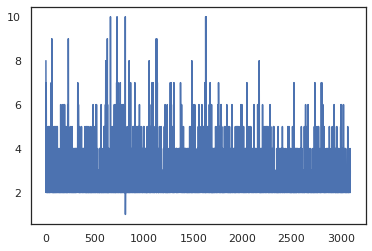

In [21]:
plt.plot(neural_grad.rundata["train_steps"])

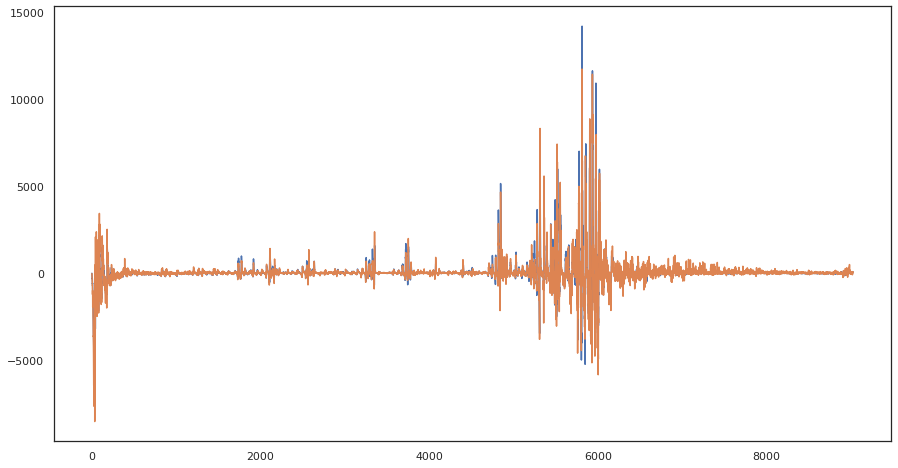

In [22]:
plt.subplots(figsize=[15, 8])
plt.plot(neural_grad.rundata["training_loss"])
plt.plot(neural_grad.rundata["validation_loss"])

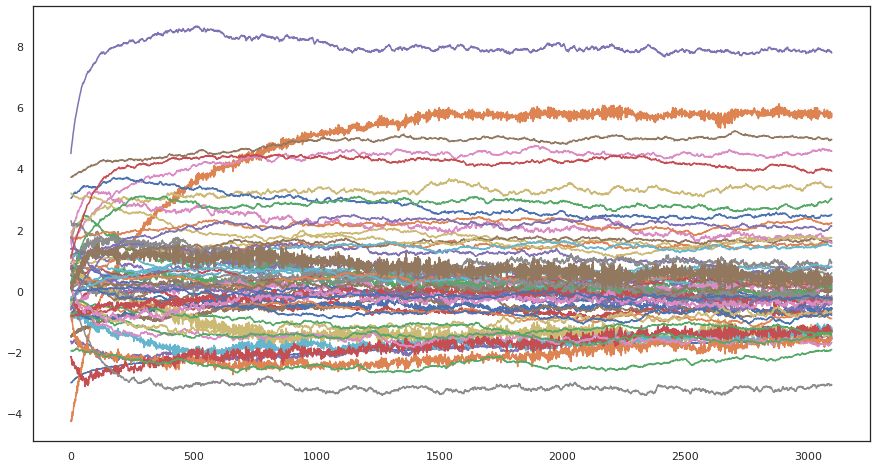

In [67]:
plt.subplots(figsize=[15, 8])
plt.plot(sgld_aux["training_mean"]);

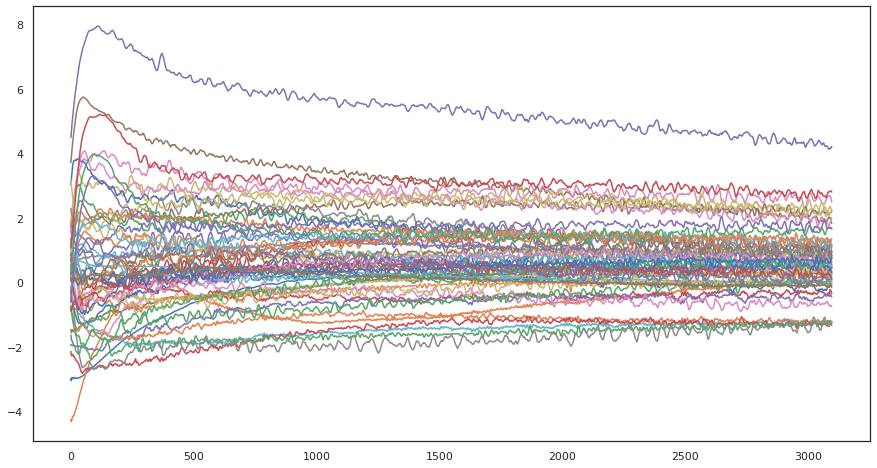

In [68]:
plt.subplots(figsize=[15, 8])
plt.plot(svgd_aux["training_mean"]);

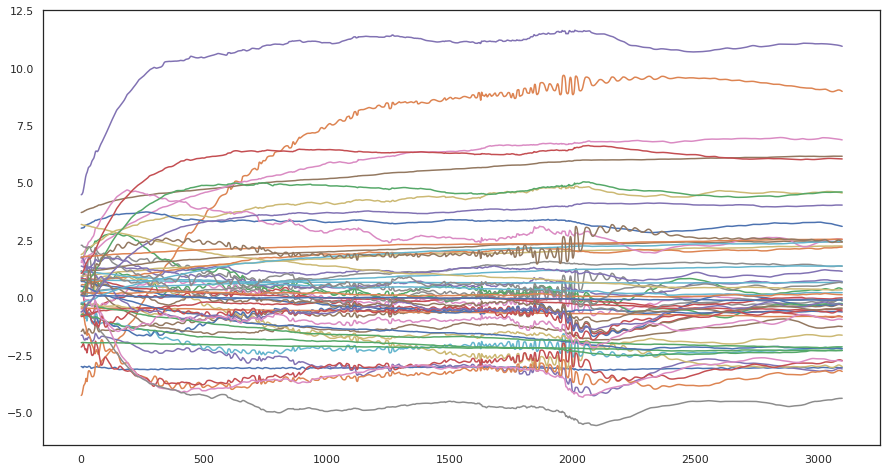

In [69]:
plt.subplots(figsize=[15, 8])
plt.plot(neural_aux["training_mean"]);

## Evaluate samples on test set

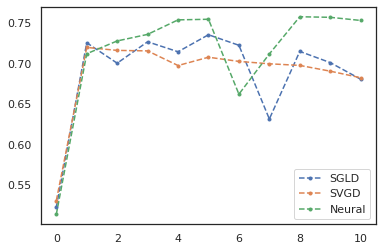

In [23]:
# plt.plot(lmc_aux["accuracy"], "--.", label="SGLD")
plt.plot(sgld_accs, "--.", label="SGLD")
plt.plot(svgd_accs, "--.", label="SVGD")
plt.plot(neural_accs, "--.", label="Neural")
plt.legend()

In [24]:
print("SGLD accuracy:", test_accuracy(sgld_samples))
print("SVGD accuracy:", test_accuracy(svgd_samples))
print("Neural accuracy:", test_accuracy(neural_samples))
key, subkey = random.split(key)
print("prior samples accuracy:", test_accuracy(dist.sample(500, seed=subkey)[:-1]))

SGLD accuracy: 0.74084145
SVGD accuracy: 0.6950165
Neural accuracy: 0.7521837
prior samples accuracy: 0.48017693


### compute log-likelihoods (train and test)

In [25]:
test_batches = get_batches(x_test, y_test, batch_size=5000)

In [29]:
x, y = next(test_batches)
test_logps = [mean_logp(x, y, batch_ravel(samples)) for samples in (sgld_samples, svgd_samples, neural_samples)]
names = ["SGLD", "SVGD", "Neural"]

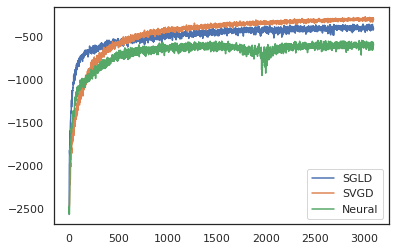

In [65]:
plt.plot(sgld_aux["training_logp"], label="SGLD")
plt.plot(onp.mean(svgd_aux["training_logp"], axis=1), label="SVGD")
plt.plot(neural_aux["logp"], label="Neural")
lines = plt.gca().get_lines()
colors = [line.get_color() for line in lines]

# for tlogp, color in zip(test_logps, colors):
#     plt.axhline(y=tlogp, color=color)


plt.legend()

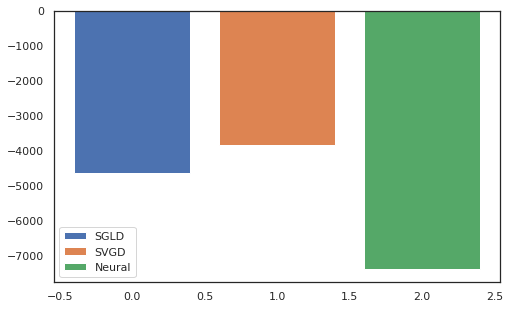

In [61]:
fig, ax = plt.subplots(figsize=[8, 5])

for i, meanlp in enumerate(test_logps):
    ax.bar(i, meanlp, label=names[i])

# ax.bar(i+1, mean_logp(x, y, batch_ravel(init_batch)), label="Init")
plt.legend()